In [1]:
import os

# Set dataset path
data_dir = "/kaggle/input/plantdisease/PlantVillage"

# Optional: check if the path exists
print(os.path.exists(data_dir))  # Should print True


True


In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),#tensor is like a multi-dimensional array (matrix) that PyTorch can do math on.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [4]:
# Dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Sizes
train_size = int(0.7 * len(dataset))   # 70% train
val_size = int(0.1 * len(dataset))     # 10% val
test_size = len(dataset) - train_size - val_size  # remaining 20% test

# Split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Define a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
       
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
       
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  
        self.dropout = nn.Dropout(p=0.5)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):#self allows you to access all the layers and attributes
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 32 * 56 * 56)          # Flatten
        x = F.relu(self.fc1(x))                # FC1 -> ReLU
        x = self.dropout(x)
        x = self.fc2(x)                       # FC2 -> output
        return x


In [6]:
num_classes = len(dataset.classes)  # Number of disease categories
model = SimpleCNN(num_classes)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()       # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer


In [8]:
num_epochs = 9

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    
    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    
    # Validation loop
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
    val_loss = val_running_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")




Epoch [1/9], Train Loss: 1.3912, Val Loss: 0.6684
Epoch [2/9], Train Loss: 0.8135, Val Loss: 0.5650
Epoch [3/9], Train Loss: 0.6057, Val Loss: 0.4425
Epoch [4/9], Train Loss: 0.4788, Val Loss: 0.3956
Epoch [5/9], Train Loss: 0.4164, Val Loss: 0.3692
Epoch [6/9], Train Loss: 0.3264, Val Loss: 0.3726
Epoch [7/9], Train Loss: 0.2868, Val Loss: 0.4527
Epoch [8/9], Train Loss: 0.2618, Val Loss: 0.4755
Epoch [9/9], Train Loss: 0.2217, Val Loss: 0.3835


In [9]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No gradient needed for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%") #rafi


Test Accuracy: 90.31%


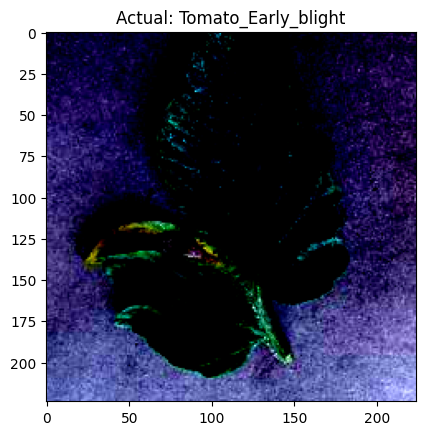

Predicted: Tomato_Early_blight
20638


In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Choose the index of the image you want to test
image_index = 5  # for example, 10th image in the test dataset
image, label = test_dataset[image_index]

# Show the image
plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.title(f"Actual: {dataset.classes[label]}")
plt.axis('on')
plt.show()

# Prepare image for the model
image = image.unsqueeze(0).to(device)  # Add batch dimension

# Make prediction
model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

predicted_class = dataset.classes[predicted.item()]
print(f"Predicted: {predicted_class}")
print(len(dataset))
